In [6]:
import pandas as pd
import os
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Set your PPMI data folder
data_dir = "PPMI_ds/"

# Helper to load CSVs
def load_csv(name):
    return pd.read_csv(os.path.join(data_dir, name))

# Load datasets
genetic_df = load_csv("iu_genetic_consensus_20250225_18Mar2025.csv")
variants_df = load_csv("PPMI_PD_Variants_Genetic_Status_WGS_20180921.csv")
sbr_df = load_csv("DaTScan_SBR_Analysis_18Mar2025.csv")
diagnosis_df = load_csv("Primary_Clinical_Diagnosis_18Mar2025.csv")

# Preview structure
print("Genetic DF:", genetic_df.columns)
print("Variants DF:", variants_df.columns)
print("SBR DF:", sbr_df.columns)
print("Diagnosis DF:", diagnosis_df.columns)

# Merge all on participant ID (usually PATNO)
merged = genetic_df.merge(variants_df, on='PATNO', how='inner')
merged = merged.merge(sbr_df, on='PATNO', how='inner')
merged = merged.merge(diagnosis_df[['PATNO', 'PRIMDIAG']], on='PATNO', how='inner')

# Drop columns with too many missing values
merged = merged.dropna(axis=1, thresh=len(merged) * 0.6)
merged = merged.drop_duplicates()

binary_cols = ['CLIA', 'GWAS', 'WES', 'WGS', 'SVs', 'SANGER', 'IU_Fingerprint', 'RNASEQ', 'RNASEQ_VIS']

for col in binary_cols:
    if col in merged.columns:
        merged[col] = merged[col].map({'X': 1, '-': 0})

non_numeric = merged.select_dtypes(include=['object']).columns
print("Non-numeric columns in X:\n", non_numeric)

from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
merged[non_numeric] = encoder.fit_transform(merged[non_numeric])


Genetic DF: Index(['PATNO', 'CLIA', 'GWAS', 'WES', 'WGS', 'SVs', 'SANGER',
       'IU_Fingerprint', 'RNASEQ', 'RNASEQ_VIS', 'APOE', 'PATHVAR_COUNT',
       'VAR_GENE', 'LRRK2', 'GBA', 'VPS35', 'SNCA', 'PRKN', 'PARK7', 'PINK1',
       'NOTES'],
      dtype='object')
Variants DF: Index(['PATNO', 'chr1:154925709:G:C_C_PMVK_rs114138760',
       'chr1:155235252:A:G_G_GBA_L444P_rs421016',
       'chr1:155235843:T:C_C_GBA_N370S_rs76763715',
       'chr1:155236246:G:A_A_GBA_T408M_rs75548401',
       'chr1:155236376:C:T_T_GBA_E365K_rs2230288',
       'chr1:155240629:C:T_T_GBA_IVS2+1_rs104886460',
       'chr1:155240660:G:GC_GC_GBA_84GG_rs387906315',
       'chr1:205754444:C:T_C_NUCKS1_rs823118',
       'chr1:226728377:T:C_C_ITPKB_rs4653767',
       'chr1:232528865:C:T_T_SIPA1L2_rs10797576',
       'chr2:101796654:T:C_C_IL1R2/MAP4K4_rs34043159',
       'chr2:134782397:C:T_C_ACMSD/TMEM163_rs6430538',
       'chr2:165277122:C:T_T_SCN3A/SCN2A_rs353116',
       'chr2:168272635:G:T_T_STK39_rs1955337'

In [7]:
# Explicitly define biomarker columns
biomarker_cols = [
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L',
    'DATSCAN_PUTAMEN_R', 'DATSCAN_PUTAMEN_L',
    'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]

# Ensure all biomarker columns exist in merged
biomarker_cols = [col for col in biomarker_cols if col in merged.columns]

# Apply KNN imputation only if there are valid biomarker columns
if biomarker_cols:
    imputer = KNNImputer(n_neighbors=5)
    merged[biomarker_cols] = imputer.fit_transform(merged[biomarker_cols])
else:
    print("⚠️ No biomarker columns found for imputation. Skipping KNN imputation.")


# Only keep Idiopathic PD and Healthy Controls
merged = merged[merged['PRIMDIAG'].isin([1, 17])]

# Map labels: PD = 1, Control = 0
merged['label'] = merged['PRIMDIAG'].map({1: 1, 17: 0})
merged = merged.drop(columns=['PRIMDIAG'])

# Feature-label split\
X = merged.drop(columns=['PATNO', 'label'])
y = merged['label']

from sklearn.impute import SimpleImputer


feature_names = X.columns

# Impute any remaining NaNs with column median
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)



scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=42
)
print("Final shape:", X_train.shape, X_test.shape)


Final shape: (1599, 100) (400, 100)


c:\Users\arsh0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['RNASEQ_VIS']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Train logistic regression (L2 regularization by default)
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

# Metrics
print("📊 Accuracy:", accuracy_score(y_test, y_pred))
print("📈 AUC-ROC:", roc_auc_score(y_test, y_proba))

# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
print("\n🧾 Confusion Matrix:\n", cm)
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

# Optional: Feature importance
import numpy as np
feature_importance = np.abs(logreg.coef_[0])
top_features = sorted(zip(feature_importance, feature_names), reverse=True)[:10]
print("\n⭐ Top 10 important features:")
for weight, name in top_features:
    print(f"{name}: {weight:.4f}")


📊 Accuracy: 0.935
📈 AUC-ROC: 0.9529865589777591

🧾 Confusion Matrix:
 [[ 33  14]
 [ 12 341]]

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.70      0.72        47
           1       0.96      0.97      0.96       353

    accuracy                           0.94       400
   macro avg       0.85      0.83      0.84       400
weighted avg       0.93      0.94      0.93       400


⭐ Top 10 important features:
SVs: 1.3995
DATSCAN_CAUDATE_L: 1.3619
DATSCAN_PUTAMEN_L: 1.1972
DATSCAN_DATE: 1.0753
DATSCAN_PUTAMEN_R_ANT: 0.8884
DATSCAN_PUTAMEN_R: 0.8456
GWAS: 0.7249
DATSCAN_CAUDATE_R: 0.6640
chr12:40321114:A:G_G_LRRK2_Y1699C_rs35801418: 0.6277
chr12:40220632:C:T_T_LRRK2_rs76904798: 0.6174


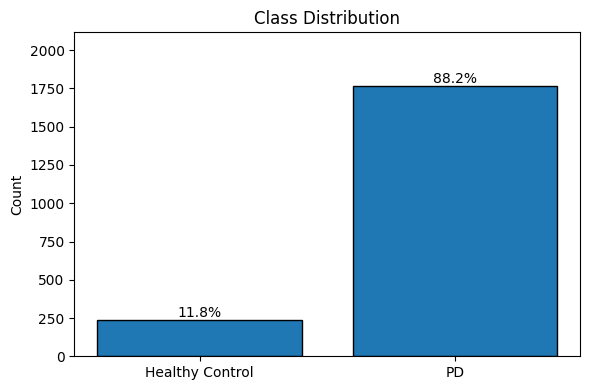

In [9]:
import matplotlib.pyplot as plt

# Use the y_test from previous context for class distribution
# For demo, assume y contains the full label array

# Simulate what y would look like
import numpy as np
from collections import Counter

# Reconstruct y as binary just for visualization
# Normally you'd pass your actual y Series here
# Assuming we already have 'y' from your session
try:
    label_counts = Counter(y)
except NameError:
    label_counts = Counter(y)

labels = ['Healthy Control', 'PD']
counts = [label_counts[0], label_counts[1]]
percentages = [count / sum(counts) * 100 for count in counts]

# Plotting
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, counts, edgecolor='black')
plt.title('Class Distribution')
plt.ylabel('Count')

# Annotate with percentage
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, f'{pct:.1f}%', 
             ha='center', va='bottom', fontsize=10)

plt.ylim(0, max(counts) * 1.2)
plt.tight_layout()
plt.show()


📊 Random Forest Accuracy: 0.935
📈 Random Forest AUC-ROC: 0.9507262973901514

🧾 Confusion Matrix:
 [[ 30  17]
 [  9 344]]

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.64      0.70        47
           1       0.95      0.97      0.96       353

    accuracy                           0.94       400
   macro avg       0.86      0.81      0.83       400
weighted avg       0.93      0.94      0.93       400



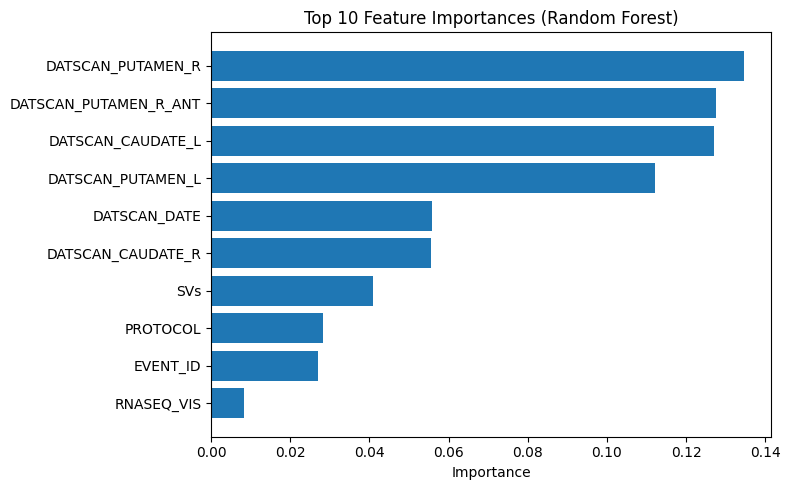

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# Metrics
print("📊 Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("📈 Random Forest AUC-ROC:", roc_auc_score(y_test, y_proba))
print("\n🧾 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

# Feature Importances
importances = rf.feature_importances_
top_idx = np.argsort(importances)[::-1][:10]  # Top 10

plt.figure(figsize=(8, 5))
plt.barh([feature_names[i] for i in top_idx][::-1], importances[top_idx][::-1])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score
from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values if hasattr(y_train, 'values') else y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values if hasattr(y_test, 'values') else y_test, dtype=torch.float32)

# Dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = MLP(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(20):
    model.train()
    for xb, yb in train_loader:
        preds = model(xb).squeeze()
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}: loss = {loss.item():.4f}")

model.eval()
with torch.no_grad():
    y_probs = model(X_test_tensor).squeeze().numpy()
    y_preds = (y_probs > 0.5).astype(int)

print("✅ MLP Accuracy:", accuracy_score(y_test, y_preds))
print("📈 MLP AUC-ROC:", roc_auc_score(y_test, y_probs))


Epoch 1: loss = 0.3657
Epoch 2: loss = 0.1995
Epoch 3: loss = 0.1745
Epoch 4: loss = 0.1350
Epoch 5: loss = 0.1257
Epoch 6: loss = 0.1887
Epoch 7: loss = 0.0163
Epoch 8: loss = 0.1430
Epoch 9: loss = 0.0178
Epoch 10: loss = 0.0612
Epoch 11: loss = 0.2447
Epoch 12: loss = 0.0645
Epoch 13: loss = 0.0434
Epoch 14: loss = 0.1209
Epoch 15: loss = 0.0411
Epoch 16: loss = 0.0618
Epoch 17: loss = 0.0085
Epoch 18: loss = 0.0314
Epoch 19: loss = 0.1208
Epoch 20: loss = 0.0117
✅ MLP Accuracy: 0.93
📈 MLP AUC-ROC: 0.9649810138026641
